# Overview
A notebook showing how to read the AMC/ASF data in the CMU Mocap and make simple visualizations. The notebook uses the code from https://github.com/CalciferZh/AMCParser/ to read and show the data

In [1]:
# !pip install -qq transforms3d

In [2]:
import os, sys
# !git clone -q https://github.com/CalciferZh/AMCParser

In [3]:
sys.path.append('AMCParser')
import amc_parser as amc

In [4]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import transforms3d 

In [24]:
from IPython.display import FileLink
from matplotlib.animation import FuncAnimation

In [5]:
BASE_DIR = Path('.') / 'input' / 'allasfamc' / 'all_asfamc'
datasets_df = pd.DataFrame({'path': list(BASE_DIR.glob('subjects/*/*.amc'))})
datasets_df['Subject'] = datasets_df['path'].map(lambda x: x.parent.stem)
datasets_df['Activity'] = datasets_df['path'].map(lambda x: x.stem.split('_')[-1].lower())
datasets_df['asf_path'] = datasets_df['path'].map(lambda x: x.parent / (x.parent.stem + '.asf'))

datasets_df.sample(3)

,path,Subject,Activity,asf_path
418,input/allasfamc/all_asfamc/subjects/113/113_12...,113,12,input/allasfamc/all_asfamc/subjects/113/113.asf
1420,input/allasfamc/all_asfamc/subjects/70/70_09.amc,70,09,input/allasfamc/all_asfamc/subjects/70/70.asf
853,input/allasfamc/all_asfamc/subjects/120/120_20...,120,20,input/allasfamc/all_asfamc/subjects/120/120.asf


In [6]:
datasets_df[['Subject', 'Activity']].describe()

,Subject,Activity
count,2514,2514
unique,112,96
top,79,01
freq,96,110


In [91]:
# find subject 111 and activity 35
# datasets_df[(datasets_df['Subject'] == '16') & (datasets_df['Activity'] == '15')]
test_rec = datasets_df[(datasets_df['Subject'] == '16') & (datasets_df['Activity'] == '15')].iloc[0]

## Parse the data
We read the joint information from the asf (one per subject) and then apply the motions (one per movement and hundreds of frames recorded)

In [93]:
test_rec['asf_path']

PosixPath('input/allasfamc/all_asfamc/subjects/16/16.asf')

In [94]:
joints = amc.parse_asf(test_rec['asf_path'])
motions = amc.parse_amc(test_rec['path'])

Draw a random frame

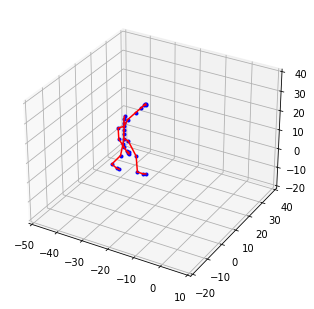

[1.22935, 17.2598, -26.9208, 0.489518, -4.81374, -3.87663]

In [96]:
frame_idx = np.random.choice(range(len(motions)))
frame_idx = 0
joints['root'].set_motion(motions[frame_idx])
joints['root'].draw()
motions[0]['root']

## Make a nice animation

In [39]:

fig = plt.figure()
ax = Axes3D(fig)

def draw_frame(i):
    ax.cla()
    ax.set_xlim3d(-50, 10)
    ax.set_ylim3d(-20, 40)
    ax.set_zlim3d(-20, 40)
    joints['root'].set_motion(motions[i])
    c_joints = joints['root'].to_dict()
    xs, ys, zs = [], [], []
    for joint in c_joints.values():
      xs.append(joint.coordinate[0, 0])
      ys.append(joint.coordinate[1, 0])
      zs.append(joint.coordinate[2, 0])
    ax.plot(zs, xs, ys, 'b.')

    for joint in c_joints.values():
      child = joint
      if child.parent is not None:
        parent = child.parent
        xs = [child.coordinate[0, 0], parent.coordinate[0, 0]]
        ys = [child.coordinate[1, 0], parent.coordinate[1, 0]]
        zs = [child.coordinate[2, 0], parent.coordinate[2, 0]]
        ax.plot(zs, xs, ys, 'r')
out_path = 'simple_animation.gif'
FuncAnimation(fig, draw_frame, range(0, len(motions), 10)).save(out_path, 
                                                  bitrate=8000,
                                                  fps=8)
plt.close('all')
FileLink(out_path)

/tmp/ipykernel_25314/2456042720.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


/home/guillaumep/sensorimotorcontrol/simple_animation.gif

# Data conversion

## Helper functions

In [16]:
def rotate_translate_frame(points, rotation, translation_hrz):
  # translate to put back at origin and rotate to be in the local frame
  points_rot_transl = rotation.dot(points - translation_hrz)
  return points_rot_transl

def inv_rotate_translate_frame(points, rotation, translation_hrz):
  points_rot_transl = rotation.T.dot(points) + translation_hrz  
  return points_rot_transl

In [14]:
# bad idea

# # https://stackoverflow.com/questions/45142959/calculate-rotation-matrix-to-align-two-vectors-in-3d-space
# def rotation_matrix_from_vectors(vec1, vec2):
#     """ Find the rotation matrix that aligns vec1 to vec2
#     :param vec1: A 3d "source" vector
#     :param vec2: A 3d "destination" vector
#     :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
#     """
#     a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
#     v = np.cross(a, b)
#     c = np.dot(a, b)
#     s = np.linalg.norm(v)
#     kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
#     rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
#     return rotation_matrix

In [17]:
def vector2d_angles(v1, v2):
    """ Returns the angle between the two 2d vectors. Faster than computing the rotation matrix between the two vectors 
    and extracting the angle from it. It's also easier, because : there's no readily available vector to matrix conversion function and 
    there's many ways/conventions to do it.
    
    """
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    cross = np.cross(v1, v2)
    dot = np.dot(v1, v2)
    return np.arctan2(cross, dot)
vector2d_angles(np.array([0,-1]), np.array([0,1]))

3.141592653589793

##  Data to Angle

In [97]:
plot = False

# intialisation parameters
# assume root joint is facing z at the initial condition (maybe not the case for all the time series, see "position in asf file")
front_vect_ini = np.array([0,0,10])  
front_vect_prec = front_vect_ini
front_vect = front_vect_ini
rotation = np.eye(3)
rot_cum = np.eye(3)
angles_cum = 0.
hrz_transl_cum = 0.
# assume root joint is centered at 0 at the initial condition (convention)
hrz_transl = np.array([0,0,0])


# recordings lists
Sxyz_ij = []
h = []
xyz_root = []
rxyz_root = []
delta = []
norm_ij = []
d1d2 = []


t_ini = 0
for t in range(t_ini,len(motions)):
    # ini the recordings for frame t
    Sxyz_ij_t = []

    joints['root'].set_motion(motions[t])
    c_joints = joints['root'].to_dict()
    if plot:
        fig = plt.figure()
        ax = Axes3D(fig,auto_add_to_figure=False)
        fig.add_axes(ax)
        ax.cla()
        ax.set_xlim3d(-50, 10)
        ax.set_ylim3d(-20, 40)
        ax.set_zlim3d(-20, 40)
    xs, ys, zs = [], [], []

    ########################################################## root joint data
    joint = c_joints['root']

    ########################################################## translation of the root joint
    ## compute d1,d2 with info (coordinate: rotation, hrz_transl) from the previous frame. d1 and d2 are iterative
    ## the first frame is at null rotation and translation
    coord_previous_frame = rotate_translate_frame(joint.coordinate[:, 0], rotation, hrz_transl)
    d1 = coord_previous_frame[0] 
    d2 = coord_previous_frame[2] 

    ## check the computation: need to put back local frame into global frame
    d = hrz_transl + rotation.T.dot(np.array([d1, 0, d2]))
    hrz_transl_cum += rotation.T.dot(np.array([d1, 0, d2]))
    # print('trans d',d,'currentcoord', joint.coordinate[:, 0], 'd_tot', hrz_transl_cum)

    ## the x,y coordinates are used to translate the frame coordinates
    hrz_transl = joint.coordinate[:, 0].copy()
    hrz_transl[1] = 0.
    
    if t == t_ini:
        # to not use because it's a translation that concerns the initialisation of the skeleton
        d1d2_ini = [d1,d2]
        # print(d1,d2)
    else:
        d1d2.append([d1,d2])

    ## the y coordinate gets into h
    h.append([joint.coordinate[1, 0]])
    


    ########################################################## rotation of the root joint    
    # compute new front vector
    front_vect = joint.matrix.dot(front_vect_ini)

    # extract the rotation around y
    # rotation absolute: from global to local frame (delta integrated)
    angles = vector2d_angles(front_vect_ini[np.array([0,2])], front_vect[np.array([0,2])])
    # rotation iterative (delta)
    angles_iter = vector2d_angles(front_vect_prec[np.array([0,2])], front_vect[np.array([0,2])])

    front_vect_prec = front_vect

    # update the cumulative rotation
    angles_cum += angles_iter

    # angles = transforms3d.euler.mat2euler(rot)
    # angles_cum = transforms3d.euler.mat2euler(rot_cum)
    # print('angles',angles,'angles_cum', angles_cum)
    
    # build the rotation matrix arount the y axis. 
    rotation = transforms3d.euler.euler2mat(0, angles, 0, 'sxyz')
    
    if t == t_ini:
        # to not use because it's a rotation that concerns the initialisation of the skeleton
        delta_ini = [angles]
    else:
        delta.append([angles_iter])
    
    # delta and d1,d2 are speed variables computed at time t for time t-1. Their values at time t=0 are not used as data.


    
    if plot:

        # see how the front vector rotate on the xz plane
        front_vect = joint.matrix.dot(front_vect) 
        front_vect[1] = 0.
        # rotation = rotation_matrix_from_vectors(front_vect, np.array([1, 0, 0]))
        output_vect = 100*rotation.dot(front_vect)

        ax.plot([front_vect[2],0], [front_vect[0],0], [17, 17], 'orange', markersize=20)    
        ax.plot([output_vect[2],0], [output_vect[0],0], [17, 17], 'r', markersize=50)

    if plot:
        for joint in c_joints.values():
            # rotation to make the body face (0, 0, 1)
            child = joint
            # child_tr_rt = rotate_translate_frame(child.coordinate[:, 0], rotation, hrz_transl)
            child_tr_rt = rotate_translate_frame(child.coordinate[:, 0], rotation, hrz_transl)
            xs.append(child_tr_rt[0])
            ys.append(child_tr_rt[1])
            zs.append(child_tr_rt[2])

        ax.plot(zs, xs, ys, 'b.')

    ########################################################## non-root joints data
    # Apply rotation and translation to all the joints
    for joint in c_joints.values():
        child = joint
        if child.parent is not None:
            parent = child.parent
            parent_tr_rt = rotate_translate_frame(parent.coordinate[:, 0], rotation, hrz_transl)
            child_tr_rt = rotate_translate_frame(child.coordinate[:, 0], rotation, hrz_transl)
            # parent_tr_rt = rotate_translate_frame(parent.coordinate[:, 0], np.eye(3), hrz_transl)
            # child_tr_rt = rotate_translate_frame(child.coordinate[:, 0], np.eye(3), hrz_transl)
            
            xs = parent_tr_rt[0] - child_tr_rt[0]
            ys = parent_tr_rt[1] - child_tr_rt[1]
            zs = parent_tr_rt[2] - child_tr_rt[2]
            segment_tr_rt = np.array([xs, ys, zs])
            Sxyz_ij_t.append(segment_tr_rt/np.linalg.norm(segment_tr_rt))
            if t == t_ini :
                norm_ij.append(np.linalg.norm(segment_tr_rt))
            # if t == t_ini +1:
            #     norm_ij_bis.append(np.linalg.norm(segment_tr_rt))

            if plot:
                xs = [child_tr_rt[0], parent_tr_rt[0]]
                ys = [child_tr_rt[1], parent_tr_rt[1]]
                zs = [child_tr_rt[2], parent_tr_rt[2]]
                
                ax.plot(zs, xs, ys, 'r')


            # xs = parent.coordinate[0, 0] - child.coordinate[0, 0]
            # ys = parent.coordinate[1, 0] - child.coordinate[1, 0]
            # zs = parent.coordinate[2, 0] - child.coordinate[2, 0]



    if plot:
        ax.plot(0, 0, 17, 'g.', markersize=10)
        # ax.plot([0, 0], [0, 100], [17, 17], 'g')
        ax.set_xlabel('Z')
        ax.set_ylabel('X')
        ax.set_zlabel('Y')
        plt.show()
    Sxyz_ij.append(Sxyz_ij_t)

In [41]:
arr_delta = np.array(delta)
arr_Sxyz_ij = np.array(Sxyz_ij[:-1]).reshape(arr_delta.shape[0], -1)
arr_h = np.array(h[:-1])#.reshape(arr_delta.shape[0], -1)
arr_d1d2 = np.array(d1d2)
print(arr_delta.shape, arr_h.shape,arr_d1d2.shape, arr_Sxyz_ij.shape)

# # concatenate them
data = np.concatenate((arr_delta, arr_h, arr_d1d2, arr_Sxyz_ij), axis=1)
print(data.shape)

(161, 1) (161, 1) (161, 2) (161, 90)
(161, 94)


In [ ]:
data_walk = data
# save data
np.save('data_walk.npy', data_walk)

In [ ]:
data_run = data
# save data
np.save('data_run.npy', data_run)

In [104]:
delta_ini

[0.0843998723555602]

In [105]:
# save initial conditions
# data_ini = np.array([d1d2_ini, delta_ini], dtype=object)
# np.save("data_ini_run.npy", data_ini)

# save initial conditions
data_ini = np.array([d1d2_ini[0], d1d2_ini[1], delta_ini[0]])
np.save("data_ini_walk.npy", data_ini)

# load data
d = np.load('data_ini_walk.npy')

In [85]:
np.save("c_joint.npy", joints['root'].to_dict())

# # # load data
# c = np.load('c_joint.npy', allow_pickle=True).item()

In [51]:
# save info about skeleteon
np.save('norm_ij.npy', norm_ij)

## Angle to Coordinate

In [64]:
data = np.load("data_btween.npy")

### 4module

In [79]:
data.shape

(161, 94)

In [49]:
def angle2Coordinate(data, data_ini, norm_ij):
    dec_delta = data[:, 0:1]
    dec_h = data[:, 1:2]
    dec_d1d2 = data[:, 2:4]
    dec_Sxyz_ij = data[:, 4:]
    dec_Sxyz_ij = dec_Sxyz_ij.reshape(dec_delta.shape[0], -1, 3)

    d1d2_ini = data_ini[0]
    delta_ini = data_ini[1]

    # start with initial condition
    rotation = np.eye(3)
    hrz_transl = np.zeros((3, 1))

    t = 0
    joint_coordinate_arr = []
    delta_cum = 0.
    hrz_transl_cum = np.zeros((3))
    for t in [i for i in range(len(motions)-1)]:

        # compute rotation and hrz_transl (need to integrate info for tranzl)
        # hrz_transl = hrz_transl + dec_xyz_root[t, :].reshape(3, 1)

        # compose previous rotation with the new one (need to be extracted from the hips...)
        # extract the rotation from the hips



        if t == 0:
            # rotation = np.eye(3)
            # the first frame is at null rotation and translation
            hrz_transl = np.zeros((3))
            rotation = np.eye(3)
            delta_cum += delta_ini[0]
            hrz_transl = np.dot(rotation.T,np.array([d1d2_ini[0], 0, d1d2_ini[1]]))
            hrz_transl_cum += hrz_transl

            rotation = transforms3d.euler.euler2mat(0,delta_cum,0)
        else:
            delta_cum += dec_delta[t-1, 0]
            rotation = transforms3d.euler.euler2mat(0,delta_cum,0)
            hrz_transl = np.dot(rotation.T,[dec_d1d2[t-1][0], 0, dec_d1d2[t-1][1]])
            hrz_transl_cum += hrz_transl
        
        # print('delta_cum', delta_cum, 'hrz_transl_cum', hrz_transl_cum)
        
        joint_coordinate = dict()
        joint_coordinate_global = dict()
        # joint_coordinate['root'] = inv_rotate_translate_frame(np.array([0, dec_h[t][0], 0]), rotation, hrz_transl_cum)
        joint_coordinate['root'] = np.array([0, dec_h[t][0], 0])
        joint_coordinate_global['root'] = inv_rotate_translate_frame(np.array([0, dec_h[t][0], 0]), rotation, hrz_transl_cum)

        # print('root', joint_coordinate['root'])
        
        idx = 0
        for idx_joint_angle, joint in enumerate(c_joints.values()):
            joint_angle = dec_Sxyz_ij[t, idx, :]
            child = joint
            if child.parent is not None:
                parent = child.parent
                # gets the coordinate in the current frame
                child_coordinate = - joint_angle*norm_ij[idx] + joint_coordinate[parent.name]
                joint_coordinate[child.name] = child_coordinate
                joint_coordinate_global[child.name] = inv_rotate_translate_frame(child_coordinate,  rotation, hrz_transl_cum)
                idx +=1

        joint_coordinate_arr.append(joint_coordinate_global)
    return joint_coordinate_arr

In [74]:
joint_coordinate_arr = angle2Coordinate(data, [d1d2_ini, delta_ini])

In [66]:
joint_coordinate_arr[0]['root']

array([  0.948937  ,  17.32612228, -32.5725    ])

In [67]:
joint_coordinate_arr

[{'root': array([  0.948937  ,  17.32612228, -32.5725    ]),
  'lhipjoint': array([  2.45865786,  15.48169971, -31.94084933]),
  'lfemur': array([  2.58980283,   9.30227399, -29.64733317]),
  'ltibia': array([  2.43925823,   2.87772393, -30.1200987 ]),
  'lfoot': array([  2.58240293,   2.44153816, -28.52405605]),
  'ltoes': array([  2.63933215,   2.64270976, -27.73745947]),
  'rhipjoint': array([ -0.59543083,  15.60374272, -31.86579948]),
  'rfemur': array([ -0.25359843,   8.97360957, -32.87606777]),
  'rtibia': array([ -0.2172675 ,   4.04546797, -36.54040995]),
  'rfoot': array([ -0.04499702,   2.75792265, -35.38049103]),
  'rtoes': array([  0.05507638,   2.54886895, -34.59356044]),
  'lowerback': array([  0.94236071,  19.45409751, -32.54671872]),
  'upperback': array([  0.90510692,  21.57142568, -32.3027376 ]),
  'thorax': array([  0.81752693,  23.7218132 , -32.04354741]),
  'lowerneck': array([  0.87239127,  25.35603201, -32.13396127]),
  'upperneck': array([  0.95080179,  27.025563

In [77]:
def video_generation(joint_coordinate_arr, c_joints, out_path = 'simple_animation.gif', display = "normal"): # type: normal, treadmill, circle
    fig = plt.figure(figsize=(10, 10))
    # ax = Axes3D(fig)
    ax = fig.add_subplot(111, projection="3d")


    def draw_frame(i):
        ax.cla()
        ax.set_xlim3d(-50, 10)
        ax.set_ylim3d(-20, 40)
        ax.set_zlim3d(-20, 40)
        joint_coordinate = joint_coordinate_arr[i].copy()
        if display == "treadmill":
            offcet = joint_coordinate['root'].copy()
            offcet[1] = 0
            for joint_coord in joint_coordinate.values():
                joint_coord -= offcet
            ax.plot(offcet[2], offcet[0], offcet[1], 'g.', markersize=10)
        
        # if display == "circle":
        #     offcet = joint_coordinate['root'].copy()
        #     offcet[1] = 0
        #     # if it goes beyon the boundary it appears on the other side
        #     circle_coord = offcet.copy()
        #     if offcet[2] > 10:
        #         circle_coord[2] = -50
        #     if circle_coord[2] < -50:
            # for joint_coord in joint_coordinate.values():
            #     joint_coord -= offcet + circle_coord
            # ax.plot(offcet[2], offcet[0], offcet[1], 'g.', markersize=10)
        
        # joints['root'].set_motion(motions[i])
        # c_joints = joints['root'].to_dict()
        xs, ys, zs = [], [], []
        for joint_coord in joint_coordinate.values():
            xs.append(joint_coord[0])
            ys.append(joint_coord[1])
            zs.append(joint_coord[2])
            ax.plot(zs, xs, ys, 'b.')

        for joint in c_joints.values():
            child = joint
            if child.parent is not None:
                parent = child.parent
                xs = [joint_coordinate[child.name][0], joint_coordinate[parent.name][0]]
                ys = [joint_coordinate[child.name][1], joint_coordinate[parent.name][1]]
                zs = [joint_coordinate[child.name][2], joint_coordinate[parent.name][2]]
                ax.plot(zs, xs, ys, 'r')
    FuncAnimation(fig, draw_frame, range(0, len(motions)-1, 10)).save(out_path, 
                                                    bitrate=8000,
                                                    fps=8)
    plt.close('all')
    FileLink(out_path)

In [78]:
video_generation(joint_coordinate_arr, c_joints, out_path = 'simple_animation1.gif', display = "treadmill")

### notebook

In [44]:
# function inverse
dec_delta = data[:, 0:1]
dec_h = data[:, 1:2]
dec_d1d2 = data[:, 2:4]
dec_Sxyz_ij = data[:, 4:]
dec_Sxyz_ij = dec_Sxyz_ij.reshape(dec_delta.shape[0], -1, 3)
print(dec_delta.shape, dec_h.shape, dec_d1d2.shape, dec_Sxyz_ij.shape)

(161, 1) (161, 1) (161, 2) (161, 30, 3)


In [45]:
# start with initial condition
rotation = np.eye(3)
hrz_transl = np.zeros((3, 1))

t = 0
joint_coordinate_arr = []
delta_cum = 0.
hrz_transl_cum = np.zeros((3))
for t in [i for i in range(len(motions)-1)]:





    # compute rotation and hrz_transl (need to integrate info for tranzl)
    # hrz_transl = hrz_transl + dec_xyz_root[t, :].reshape(3, 1)

    # compose previous rotation with the new one (need to be extracted from the hips...)
    # extract the rotation from the hips



    if t == 0:
        # rotation = np.eye(3)
        # the first frame is at null rotation and translation
        hrz_transl = np.zeros((3))
        rotation = np.eye(3)
        delta_cum += delta_ini[0]
        hrz_transl = np.dot(rotation.T,np.array([d1d2_ini[0], 0, d1d2_ini[1]]))
        hrz_transl_cum += hrz_transl

        rotation = transforms3d.euler.euler2mat(0,delta_cum,0)
    else:
        delta_cum += dec_delta[t-1, 0]
        rotation = transforms3d.euler.euler2mat(0,delta_cum,0)
        hrz_transl = np.dot(rotation.T,[dec_d1d2[t-1][0], 0, dec_d1d2[t-1][1]])
        hrz_transl_cum += hrz_transl
    
    # print('delta_cum', delta_cum, 'hrz_transl_cum', hrz_transl_cum)
    
    joint_coordinate = dict()
    joint_coordinate_global = dict()
    # joint_coordinate['root'] = inv_rotate_translate_frame(np.array([0, dec_h[t][0], 0]), rotation, hrz_transl_cum)
    joint_coordinate['root'] = np.array([0, dec_h[t][0], 0])
    joint_coordinate_global['root'] = inv_rotate_translate_frame(np.array([0, dec_h[t][0], 0]), rotation, hrz_transl_cum)

    # print('root', joint_coordinate['root'])
    
    idx = 0
    for idx_joint_angle, joint in enumerate(c_joints.values()):
        joint_angle = dec_Sxyz_ij[t, idx, :]
        child = joint
        if child.parent is not None:
            parent = child.parent
            # gets the coordinate in the current frame
            child_coordinate = - joint_angle*norm_ij[idx] + joint_coordinate[parent.name]
            joint_coordinate[child.name] = child_coordinate
            joint_coordinate_global[child.name] = inv_rotate_translate_frame(child_coordinate,  rotation, hrz_transl_cum)
            idx +=1

    joint_coordinate_arr.append(joint_coordinate_global)

In [ ]:
# joint_coordinate
# for joint_coordinate in joint_coordinate_arr:
#     # plot joint_coordinate
#     fig = plt.figure()
#     ax = Axes3D(fig,auto_add_to_figure=False)
#     fig.add_axes(ax)
#     ax.cla()
#     ax.set_xlim3d(-50, 10)
#     ax.set_ylim3d(-20, 40)
#     ax.set_zlim3d(-20, 40)
#     xs, ys, zs = [], [], []
#     for joint in joint_coordinate.values():
#         xs.append(joint[0])
#         ys.append(joint[1])
#         zs.append(joint[2])
#     ax.plot(zs, xs, ys, 'b.')

#     for joint in c_joints.values():
#         child = joint
#         if child.parent is not None:
#             parent = child.parent
#             xs = [joint_coordinate[child.name][0], joint_coordinate[parent.name][0]]
#             ys = [joint_coordinate[child.name][1], joint_coordinate[parent.name][1]]
#             zs = [joint_coordinate[child.name][2], joint_coordinate[parent.name][2]]
#             ax.plot(zs, xs, ys, 'r')
#     plt.show()

## video

In [46]:
fig = plt.figure()
ax = Axes3D(fig)

def draw_frame(i):
    ax.cla()
    ax.set_xlim3d(-50, 10)
    ax.set_ylim3d(-20, 40)
    ax.set_zlim3d(-20, 40)
    joint_coordinate = joint_coordinate_arr[i]
    # joints['root'].set_motion(motions[i])
    # c_joints = joints['root'].to_dict()
    xs, ys, zs = [], [], []
    for joint_coord in joint_coordinate.values():
      xs.append(joint_coord[0])
      ys.append(joint_coord[1])
      zs.append(joint_coord[2])
    ax.plot(zs, xs, ys, 'b.')

    for joint in c_joints.values():
      child = joint
      if child.parent is not None:
        parent = child.parent
        xs = [joint_coordinate[child.name][0], joint_coordinate[parent.name][0]]
        ys = [joint_coordinate[child.name][1], joint_coordinate[parent.name][1]]
        zs = [joint_coordinate[child.name][2], joint_coordinate[parent.name][2]]
        ax.plot(zs, xs, ys, 'r')
out_path = 'simple_animation.gif'
FuncAnimation(fig, draw_frame, range(0, len(motions)-1, 10)).save(out_path, 
                                                  bitrate=8000,
                                                  fps=8)
plt.close('all')
FileLink(out_path)

/tmp/ipykernel_1094/705251104.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


/home/guillaumep/sensorimotorcontrol/simple_animation.gif

In [35]:
data_walk = data
# save data
np.save('data_walk.npy', data_walk)

In [45]:
data_run = data
# save data
np.save('data_run.npy', data_run)


-26.9208 1.22935 17.2598


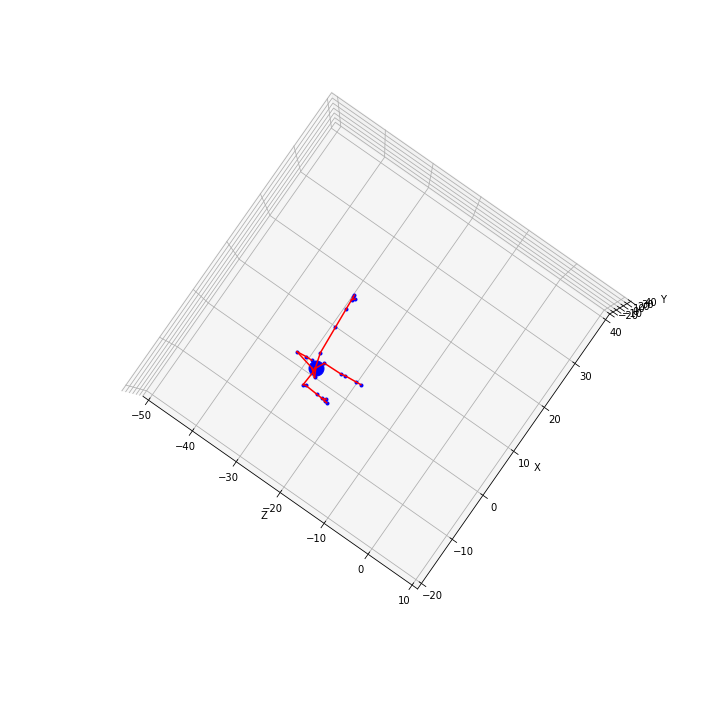

In [522]:
# for i in [1, 10, 20, 30, 50, 100 ]:
i = 0
fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig)
# ax = Axes3D(fig,auto_add_to_figure=False)
ax = fig.add_subplot(111, projection="3d")
ax.cla()
ax.set_xlim3d(-50, 10)
ax.set_ylim3d(-20, 40)
ax.set_zlim3d(-20, 40)
joints['root'].set_motion(motions[i])
c_joints = joints['root'].to_dict()
xs, ys, zs = [], [], []
for joint in c_joints.values():
    xs.append(joint.coordinate[0, 0])
    ys.append(joint.coordinate[1, 0])
    zs.append(joint.coordinate[2, 0])
    if joint.name == 'root':
        print(zs[-1], xs[-1], ys[-1])
        ax.plot(zs[-1], xs[-1], ys[-1], 'b.', markersize=30)
        # ax.plot(-26,1,17, 'g.', markersize=100)
        # ax.plot(-26.9208, 1.22935,17.2598, 'g.', markersize=100)
ax.plot(zs, xs, ys, 'b.')

for joint in c_joints.values():
    child = joint
    if child.parent is not None:
        parent = child.parent
        xs = [child.coordinate[0, 0], parent.coordinate[0, 0]]
        ys = [child.coordinate[1, 0], parent.coordinate[1, 0]]
        zs = [child.coordinate[2, 0], parent.coordinate[2, 0]]
        ax.plot(zs, xs, ys, 'r')
# a = motions[i]['root']
# ax.plot([a[2], a[2+3]], [a[0], a[0+3]], [a[1], a[1+3]], 'g')
# ax.plot(0,0,0, 'g.', markersize=10)
# ax.plot(-26.9208, 17.2598, 1.22935, 'g.', markersize=10)

# print(joints['root'].coordinate)
# ax.plot([(0)])
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.view_init(azim=-55, elev=88)
plt.show()

In [35]:
def get_joint_pos_dict(c_joints, c_motion):
    c_joints['root'].set_motion(c_motion)
    out_dict = {}
    for k1, v1 in c_joints['root'].to_dict().items():
        for k2, v2 in zip('xyz', v1.coordinate[:, 0]):
            out_dict['{}_{}'.format(k1, k2)] = v2
    return out_dict
motion_df = pd.DataFrame([get_joint_pos_dict(joints, c_motion) for c_motion in motions])
motion_df.to_csv('motion.csv', index=False)
motion_df.sample(3)

,root_x,root_y,root_z,lhipjoint_x,lhipjoint_y,lhipjoint_z,lfemur_x,lfemur_y,lfemur_z,ltibia_x,...,rwrist_z,rhand_x,rhand_y,rhand_z,rfingers_x,rfingers_y,rfingers_z,rthumb_x,rthumb_y,rthumb_z
1417,1.86011,15.5090,31.1852,-0.133416,13.792885,32.652101,-0.701935,7.880296,31.520271,0.851723,...,26.707636,1.863680,13.009243,26.434957,1.839637,12.649275,26.257515,1.658248,12.901881,26.610518
628,12.52270,16.0385,-26.7150,14.595490,14.355107,-28.108100,15.491060,8.538419,-26.719912,14.070740,...,-22.370090,10.202618,13.251669,-22.120636,10.075607,12.907935,-21.955242,10.425554,13.089027,-22.212274
546,3.95588,15.8710,-27.6094,4.399621,14.192737,-30.070604,7.211910,8.847131,-30.350770,2.929814,...,-24.139848,7.485046,12.875517,-23.959946,7.631969,12.516011,-23.855982,7.531840,12.781630,-24.231140


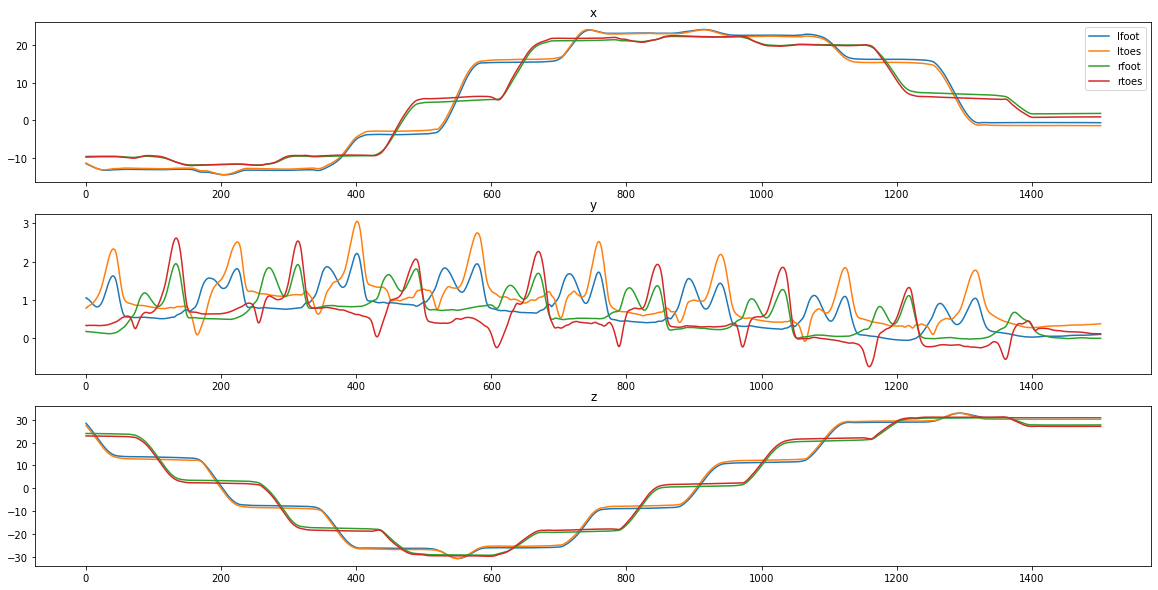

In [15]:
fig, m_axs = plt.subplots(3, 1, figsize=(20, 10))
for c_x, c_ax in zip('xyz', m_axs):
    for joint_name in joints.keys():
        if ('foot' in joint_name) or ('toes' in joint_name):
            c_ax.plot(motion_df['{}_{}'.format(joint_name, c_x)], label=joint_name)
    c_ax.set_title(c_x);
m_axs[0].legend()

In [16]:
motion_df

,root_x,root_y,root_z,lhipjoint_x,lhipjoint_y,lhipjoint_z,lfemur_x,lfemur_y,lfemur_z,ltibia_x,...,rwrist_z,rhand_x,rhand_y,rhand_z,rfingers_x,rfingers_y,rfingers_z,rthumb_x,rthumb_y,rthumb_z
0,-9.86410,15.5200,26.3548,-12.238206,13.756011,25.786504,-12.101608,7.937496,24.146630,-11.836375,...,24.257797,-5.242267,12.054913,24.186351,-5.125539,11.673348,24.137121,-5.495155,11.958704,24.079850
1,-9.87933,15.5193,26.2715,-12.254909,13.758721,25.698805,-12.125860,7.977170,23.932458,-11.887516,...,24.127686,-5.270426,12.039790,24.052994,-5.150400,11.659580,24.001281,-5.522935,11.941755,23.947263
2,-9.88265,15.5154,26.2075,-12.264244,13.757890,25.650575,-12.151394,8.021693,23.741053,-11.945303,...,23.980574,-5.300215,12.023185,23.908411,-5.177508,11.643510,23.859114,-5.552478,11.922369,23.804731
3,-9.90224,15.5179,26.1171,-12.284964,13.766286,25.546599,-12.169517,8.066794,23.530308,-12.000836,...,23.846200,-5.333744,12.018361,23.774587,-5.206767,11.639994,23.726055,-5.585343,11.914136,23.672678
4,-9.91657,15.5166,26.0353,-12.302085,13.769887,25.461443,-12.189165,8.111698,23.331863,-12.056882,...,23.707125,-5.366294,12.009208,23.636262,-5.236131,11.631814,23.588605,-5.617383,11.902342,23.535841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1.83330,15.6145,30.4078,-0.139548,13.891540,31.894500,-0.531615,7.889389,31.275280,0.899934,...,26.076535,2.157324,13.020952,25.807548,2.153454,12.658636,25.633328,1.958949,12.903532,25.984777
1499,1.83197,15.6139,30.4045,-0.140870,13.893128,31.893742,-0.530141,7.890216,31.280167,0.900801,...,26.087906,2.135216,13.022927,25.820476,2.128604,12.660004,25.647609,1.936166,12.907586,25.998314
1500,1.82861,15.6144,30.4044,-0.141336,13.894093,31.898004,-0.531518,7.890947,31.287292,0.897113,...,26.084357,2.136492,13.017212,25.814802,2.131803,12.655148,25.640078,1.937557,12.900118,25.991618
1501,1.82682,15.6138,30.4028,-0.140999,13.894041,31.899836,-0.531200,7.890585,31.292201,0.895652,...,26.088755,2.124505,13.014466,25.819977,2.117896,12.652114,25.645915,1.924778,12.898826,25.996858


### Clean up bumpf
Kaggle gets upset if there are too many directories in the output

In [13]:
!rm -rf AMCParser